In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
from pathlib import Path

In [2]:
# Dataset
DATASET_DIR = './multi-cancer'
CANCER_TYPE = "Oral Cancer"

# Image
H, W = 224, 224
MEAN = torch.tensor([0.5528, 0.5140, 0.7288])
STD = torch.tensor([0.1615, 0.1922, 0.1221])

# Training
BATCH_SIZE = 32
TRAIN_PHASE1 = True
TRAIN_PHASE2 = True
PHASE1_EPOCHS = 10
PHASE2_EPOCHS = 20
PHASE1_PATIENTS = 3
PHASE2_PATIENTS = 5

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
cancer_dir = os.path.join(DATASET_DIR, CANCER_TYPE)
class_names = sorted([d for d in os.listdir(cancer_dir) 
                      if os.path.isdir(os.path.join(cancer_dir, d))])
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

print("Classes:", class_names)
print("Class to index:", class_to_idx)

image_paths = []
image_labels = []
class_counts = {cls_name: 0 for cls_name in class_names}

for class_name in class_names:
    class_dir = os.path.join(cancer_dir, class_name)
    for filename in os.listdir(class_dir):
        path = os.path.join(class_dir, filename)
        if os.path.isfile(path):
            image_paths.append(path)
            image_labels.append(class_to_idx[class_name])
            class_counts[class_name] += 1

Classes: ['oral_normal', 'oral_scc']
Class to index: {'oral_normal': 0, 'oral_scc': 1}


In [6]:
# Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')
print("Total image count:", len(image_paths))
print("\nClass distribution:")
for cls_name, count in class_counts.items():
    print(f"  {cls_name}: {count}")
print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['./multi-cancer\\Oral Cancer\\oral_scc\\oral_scc_3146.jpg', './multi-cancer\\Oral Cancer\\oral_scc\\oral_scc_0565.jpg', './multi-cancer\\Oral Cancer\\oral_scc\\oral_scc_2261.jpg', './multi-cancer\\Oral Cancer\\oral_normal\\oral_normal_0761.jpg', './multi-cancer\\Oral Cancer\\oral_normal\\oral_normal_3780.jpg'] 

[1, 1, 1, 0, 0] 

Total image count: 10002

Class distribution:
  oral_normal: 5001
  oral_scc: 5001
Image size: (512, 512)
Image mode: RGB
Image size: (512, 512)
Image mode: RGB


In [7]:
#train, val, test = 70%, 15%, 15%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print("Training size:", len(train_paths))
print("Validation size:", len(val_paths))
print("Testing size:", len(test_paths))

Training size: 7001
Validation size: 1500
Testing size: 1501


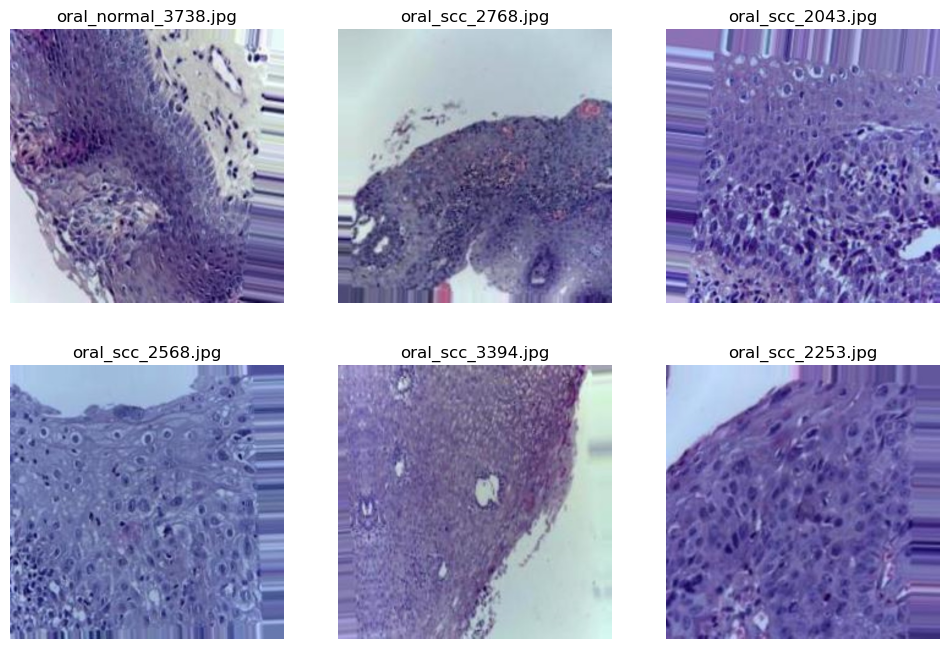

In [8]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [9]:
# # Calculate Mean and Standard Deviation of the training set
# transform = transforms.Compose([
#     transforms.Resize((H, W)),
#     transforms.ToTensor()
# ])

# mean = 0.
# std = 0.
# n = 0

# for path in tqdm(train_paths):
#     img = Image.open(path).convert('RGB')
#     img = transform(img)  # shape: [3, H, W]
#     mean += img.mean(dim=[1,2])
#     std += img.std(dim=[1,2])
#     n += 1

# mean /= n
# std /= n

# print("Mean:", mean)
# print("Std:", std)

In [10]:
#Data augmentation 
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [11]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# For train_loader, val_loader and test_loader
# There are approximately len({}_paths) / BATCH_SIZE batches in total
# Each batch has a shape of [BATCH_SIZE, 3, H, W]
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Training", leave=False)

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

        current_loss = total_loss / total_samples
        current_acc = total_correct / total_samples
        loop.set_postfix(loss=current_loss, acc=current_acc)

    return total_loss / total_samples, total_correct / total_samples

In [13]:
@torch.no_grad()
def eval_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Validating", leave=False)

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

        current_loss = total_loss / total_samples
        current_acc = total_correct / total_samples
        loop.set_postfix(loss=current_loss, acc=current_acc)

    return total_loss / total_samples, total_correct / total_samples

In [14]:
def save_checkpoint(model, optimizer, epoch, val_acc, train_losses, val_losses, save_path):
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "val_acc": val_acc,
        "train_losses": train_losses,
        "val_losses": val_losses
    }, save_path)

    print(f"[Checkpoint Saved] epoch={epoch}, val_acc={val_acc:.4f} → {save_path}")

def load_checkpoint(model, optimizer, path, device):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No checkpoint found at '{path}'")

    ckpt = torch.load(path, map_location=device)

    model.load_state_dict(ckpt["model_state_dict"])

    if optimizer is not None:
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])

    start_epoch = ckpt.get("epoch", 0)
    best_val_acc = ckpt.get("val_acc", 0.0)

    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])

    print(f"[Checkpoint Loaded] epoch={start_epoch}, best_val_acc={best_val_acc:.4f}")
    return model, optimizer, start_epoch, best_val_acc, train_losses, val_losses

In [15]:
@torch.no_grad()
def evaluate_on_test(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = (all_preds == all_labels).mean()
    print(f"\nTest Accuracy: {acc:.4f}")

    if class_names is None:
        class_names = ["normal", "SCC"]

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Set)")
    plt.tight_layout()
    plt.show()

### Phase 1: Train with frozen backbone

In [16]:
NUM_CLASSES = len(class_names)
print(f"Number of classes: {NUM_CLASSES}")

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES) # type: ignore

for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

Number of classes: 2


In [17]:
best_val_acc = 0.0

checkpoint_dir = Path('checkpoints') / CANCER_TYPE.lower().replace(" ", "_") / 'phase1'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "best_model.pth"

if TRAIN_PHASE1:
    train_losses = []
    val_losses = []
    start_epoch = 0
    patience_counter = 0

    for epoch in range(PHASE1_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"[Epoch {epoch+1}/{PHASE1_EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint(model, optimizer, epoch + 1, best_val_acc, train_losses, val_losses, checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PHASE1_PATIENTS:
                print("Early stopping triggered.")
                break
else:
    model, optimizer, start_epoch, best_val_acc, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path, device)

Training:   0%|          | 0/219 [00:00<?, ?it/s]

[Epoch 1/10] Train Loss: 0.5045, Acc: 0.7523 | Val Loss: 0.4497, Acc: 0.7700
[Checkpoint Saved] epoch=1, val_acc=0.7700 → checkpoints\oral_cancer\phase1\best_model.pth


[Epoch 2/10] Train Loss: 0.4352, Acc: 0.7977 | Val Loss: 0.4085, Acc: 0.8173
[Checkpoint Saved] epoch=2, val_acc=0.8173 → checkpoints\oral_cancer\phase1\best_model.pth


[Epoch 3/10] Train Loss: 0.4166, Acc: 0.8126 | Val Loss: 0.4037, Acc: 0.8140


[Epoch 4/10] Train Loss: 0.4078, Acc: 0.8113 | Val Loss: 0.3936, Acc: 0.8153


[Epoch 5/10] Train Loss: 0.4059, Acc: 0.8083 | Val Loss: 0.3805, Acc: 0.8273
[Checkpoint Saved] epoch=5, val_acc=0.8273 → checkpoints\oral_cancer\phase1\best_model.pth


[Epoch 6/10] Train Loss: 0.4028, Acc: 0.8136 | Val Loss: 0.3714, Acc: 0.8360
[Checkpoint Saved] epoch=6, val_acc=0.8360 → checkpoints\oral_cancer\phase1\best_model.pth


[Epoch 7/10] Train Loss: 0.3904, Acc: 0.8213 | Val Loss: 0.3814, Acc: 0.8207


[Epoch 8/10] Train Loss: 0.3990, Acc: 0.8163 | Val Loss: 0.3650, Acc: 0.8273


[Epoch 9/10] Train Loss: 0.3947, Acc: 0.8249 | Val Loss: 0.3712, Acc: 0.8253
Early stopping triggered.


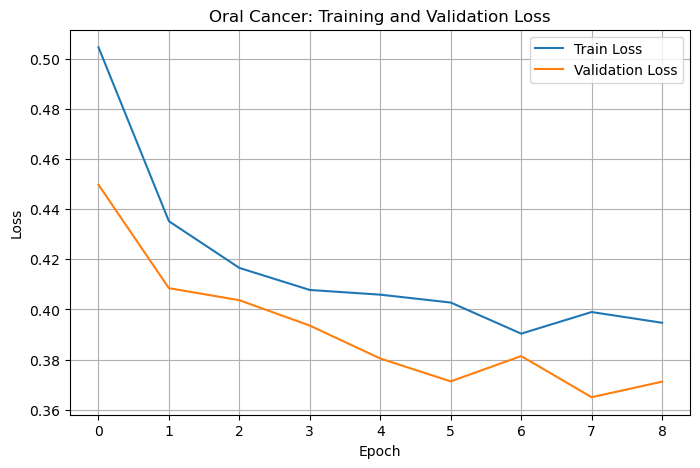

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(CANCER_TYPE + ': Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Phase 2: Fine-tune the entire model

In [19]:
for param in model.features.parameters():
    param.requires_grad = True

model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [20]:
checkpoint_dir = Path('checkpoints') / CANCER_TYPE.lower().replace(" ", "_") / 'phase2'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "best_model.pth"

if TRAIN_PHASE2:
    train_losses = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(PHASE2_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"[Phase2 Epoch {epoch+1}/{PHASE2_EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint(model, optimizer, epoch + 1, best_val_acc, train_losses, val_losses, checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PHASE2_PATIENTS:
                print("Early stopping triggered.")
                break
else:
    model, optimizer, start_epoch, best_val_acc, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path, device)

[Phase2 Epoch 1/20] Train Loss: 0.2564, Acc: 0.8927 | Val Loss: 0.1453, Acc: 0.9447
[Checkpoint Saved] epoch=1, val_acc=0.9447 → checkpoints\oral_cancer\phase2\best_model.pth


[Phase2 Epoch 2/20] Train Loss: 0.1261, Acc: 0.9519 | Val Loss: 0.0972, Acc: 0.9647
[Checkpoint Saved] epoch=2, val_acc=0.9647 → checkpoints\oral_cancer\phase2\best_model.pth


[Phase2 Epoch 3/20] Train Loss: 0.0845, Acc: 0.9644 | Val Loss: 0.0852, Acc: 0.9700
[Checkpoint Saved] epoch=3, val_acc=0.9700 → checkpoints\oral_cancer\phase2\best_model.pth


[Phase2 Epoch 4/20] Train Loss: 0.0605, Acc: 0.9761 | Val Loss: 0.0752, Acc: 0.9733
[Checkpoint Saved] epoch=4, val_acc=0.9733 → checkpoints\oral_cancer\phase2\best_model.pth


[Phase2 Epoch 5/20] Train Loss: 0.0544, Acc: 0.9781 | Val Loss: 0.0525, Acc: 0.9753
[Checkpoint Saved] epoch=5, val_acc=0.9753 → checkpoints\oral_cancer\phase2\best_model.pth


[Phase2 Epoch 6/20] Train Loss: 0.0454, Acc: 0.9820 | Val Loss: 0.0507, Acc: 0.9800
[Checkpoint Saved] epoch=6, val_acc=0.9800 → checkpoints\oral_cancer\phase2\best_model.pth


[Phase2 Epoch 7/20] Train Loss: 0.0373, Acc: 0.9850 | Val Loss: 0.0488, Acc: 0.9793


[Phase2 Epoch 8/20] Train Loss: 0.0331, Acc: 0.9873 | Val Loss: 0.0590, Acc: 0.9793


[Phase2 Epoch 9/20] Train Loss: 0.0306, Acc: 0.9870 | Val Loss: 0.0357, Acc: 0.9860
[Checkpoint Saved] epoch=9, val_acc=0.9860 → checkpoints\oral_cancer\phase2\best_model.pth


[Phase2 Epoch 10/20] Train Loss: 0.0328, Acc: 0.9880 | Val Loss: 0.0377, Acc: 0.9867
[Checkpoint Saved] epoch=10, val_acc=0.9867 → checkpoints\oral_cancer\phase2\best_model.pth


[Phase2 Epoch 11/20] Train Loss: 0.0288, Acc: 0.9887 | Val Loss: 0.0385, Acc: 0.9873
[Checkpoint Saved] epoch=11, val_acc=0.9873 → checkpoints\oral_cancer\phase2\best_model.pth


[Phase2 Epoch 12/20] Train Loss: 0.0251, Acc: 0.9904 | Val Loss: 0.0447, Acc: 0.9847


[Phase2 Epoch 13/20] Train Loss: 0.0294, Acc: 0.9886 | Val Loss: 0.0449, Acc: 0.9853


[Phase2 Epoch 14/20] Train Loss: 0.0291, Acc: 0.9891 | Val Loss: 0.0482, Acc: 0.9853


[Phase2 Epoch 15/20] Train Loss: 0.0218, Acc: 0.9921 | Val Loss: 0.0359, Acc: 0.9860


[Phase2 Epoch 16/20] Train Loss: 0.0205, Acc: 0.9926 | Val Loss: 0.0362, Acc: 0.9873
Early stopping triggered.


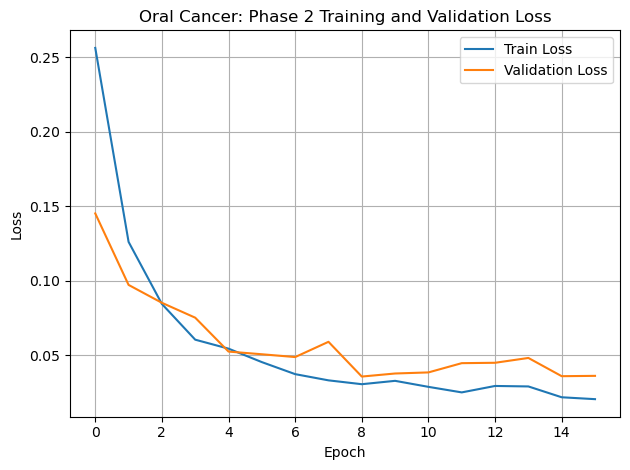

In [23]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(CANCER_TYPE + ': Phase 2 Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluation

Class names: ['oral_normal', 'oral_scc']


Testing: 100%|██████████| 47/47 [00:37<00:00,  1.26it/s]


Test Accuracy: 0.9827

Classification Report:
              precision    recall  f1-score   support

 oral_normal       0.99      0.98      0.98       751
    oral_scc       0.98      0.99      0.98       750

    accuracy                           0.98      1501
   macro avg       0.98      0.98      0.98      1501
weighted avg       0.98      0.98      0.98      1501



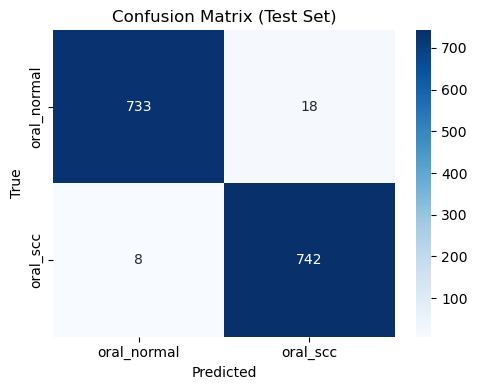

In [22]:
print("Class names:", class_names)
evaluate_on_test(model, test_loader, device, class_names=class_names)